In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import arviz as az

In [2]:
paths = ["../../data/bayesian_inference/processed/params/tuned_clim_idv.npy",
         "../../data/bayesian_inference/processed/params/mixtral_clim_idv.npy",
         "../../data/bayesian_inference/processed/params/dm_clim_idv.npy",
         "../../data/bayesian_inference/processed/params/gpt_clim_idv.npy"]

length = len(np.load(paths[0]))
data = np.zeros((len(paths), length, 3))

for i, path in enumerate(paths):
    params = np.load(path)
    data[i, :, 0] = params[:, 0]  # mean
    data[i, :, 1] = params[:, 1]  # higher_bound
    data[i, :, 2] = params[:, 2]  # lower_bound

In [3]:
init_ops = np.array([-2, -1, 0, 1, 2])
data[0, 3:-6].round(2)

array([[-0.33,  0.05,  0.05],
       [ 1.34,  0.04,  0.04],
       [ 1.48,  0.03,  0.03],
       [ 1.77,  0.03,  0.03],
       [ 2.  ,  0.  ,  0.  ]])

In [4]:
base_path = "../../data/simulations/processed/"
data_paths = ["mixtral_tuned_clim_data.csv", "mixtral_8x7b_data_clim.csv", "dolphin_mixtral_data_clim.csv", "gpt_4o_mini_data_clim.csv"]
model_paths = ["tuned", "mixtral", "dm", "gpt"]

topic_biases = np.zeros((4,5))
topic_biases[0] = np.array([-0.33, 1.34, 1.48, 1.77, 1.99])
topic_biases[1] = np.array([1.88, 1.99, 1.997, 1.85, 1.998])
topic_biases[2] = np.array([0.7, 0.8, 1.1, 1.6, 1.6])
topic_biases[3] = np.array([1.88, 1.92, 1.88, 1.92, 1.88])

effect_sizes = []

for p, path in enumerate(data_paths):
    df = pd.read_csv(base_path + path)

    # timesteps start from 1
    df.loc[:, "t"] = df.loc[:, "t"]+1

    # add a column to indicate whether the row is a discussion (t>1) or initial message (t=1) 
    df["is_discussion"] = (df["t"] != 1).astype(int)
    df["is_responder"] = (df["is_initiator"] != 1).astype(int)

    # Add x_0 column for anchoring effect
    for i in range(len(df)):
        if df.loc[i, "t"] == 1:
            df.loc[i, "x_0"] = df.loc[i, "x_j"]

        else:
            df.loc[i, "x_0"] = df.loc[i-2, "x_0"]

    # convert to numpy
    delta_x = df['dx'].to_numpy() # opinion change from agent i (t to t+1)
    x_i = df['x_i'].to_numpy() # opinion of agent i at time t
    H_i = df["H_i"].to_numpy() # uncertainty of agent i at time t
    x_j = df['x_j'].to_numpy() # opinion of agent j at time t
    H_j = df['H_j'].to_numpy() # uncertainty of agent j at time t
    t_data = df['t'].to_numpy() # time step
    d_data = df['delta'].to_numpy() # question framing (-1 or 1)
    is_climate = df['is_climate'].to_numpy() # binary indicator for climate question
    is_ai = df['is_ai'].to_numpy() # binary indicator for AI question
    is_gwd = df['is_gwd'].to_numpy() # binary indicator for wealth distribution question
    is_discussion = df['is_discussion'].to_numpy() # binary indicator for discussion (1) or initial message (0)
    x_0 = df['x_0'].to_numpy()
    is_responder = df['is_responder'].to_numpy()

    # add 5 new zero columns for binary initial opinion encoding
    df['is-2'] = 0
    df['is-1'] = 0
    df['is0'] = 0
    df['is1'] = 0
    df['is2'] = 0

    # fill the new columns with binary encoding of initial opinion
    df.loc[df['init_x_i'] == -2, 'is-2'] = 1
    df.loc[df['init_x_i'] == -1, 'is-1'] = 1
    df.loc[df['init_x_i'] == 0, 'is0'] = 1
    df.loc[df['init_x_i'] == 1, 'is1'] = 1
    df.loc[df['init_x_i'] == 2, 'is2'] = 1

    is_minus_2 = df['is-2'].to_numpy() # binary indicator for initial opinion -2
    is_minus_1 = df['is-1'].to_numpy() # binary indicator for initial opinion -1
    is_0 = df['is0'].to_numpy() # binary indicator for initial opinion 0
    is_1 = df['is1'].to_numpy() # binary indicator for initial opinion 1
    is_2 = df['is2'].to_numpy() # binary indicator for initial opinion 2

    trace = az.from_netcdf("../../data/bayesian_inference/raw/traces/full_model_trace_" + model_paths[p] + "_clim_idv.nc")

    # extract posterior samples
    alpha = trace.posterior["alpha"].values.flatten()

    # extract mean
    tau = trace.posterior["tau"].values.flatten().mean()

    # predictor and observable 
    predictor = np.exp(-t_data/tau.mean())*(x_j - x_i)
    observable = delta_x

    # calculate effect size distribution of alpha
    effect_size_alpha = alpha * predictor.std() / observable.std()
    effect_sizes.append(effect_size_alpha)


    # for beta_topic
    beta_t = trace.posterior["beta_t"].values.flatten()
    b0 = topic_biases[p, 0]
    b1 = topic_biases[p, 1]
    b2 = topic_biases[p, 2]
    b3 = topic_biases[p, 3]
    b4 = topic_biases[p, 4]

    b = b0*is_minus_2 + b1*is_minus_1 + b2*is_0 + b3*is_1 + b4*is_2
    n = d_data*b 
    predictor = n - x_i

    effect_size_beta_t = beta_t * (predictor.std() / observable.std())
    effect_sizes.append(effect_size_beta_t)

    # for beta_agree
    beta_a = trace.posterior["beta_a"].values.flatten()
    a  = trace.posterior['a'].values.flatten().mean()
    predictor = a - x_i

    effect_size_beta_a = beta_a * (predictor.std() / observable.std())
    effect_sizes.append(effect_size_beta_a)


    # for beta_anchor
    beta_c = trace.posterior["beta_c"].values.flatten()
    predictor = (x_0 - x_i)* is_responder

    effect_size_beta_c = beta_c * (predictor.std() / observable.std()) 
    effect_sizes.append(effect_size_beta_c)

    print(len(effect_sizes))

4
8
12
16


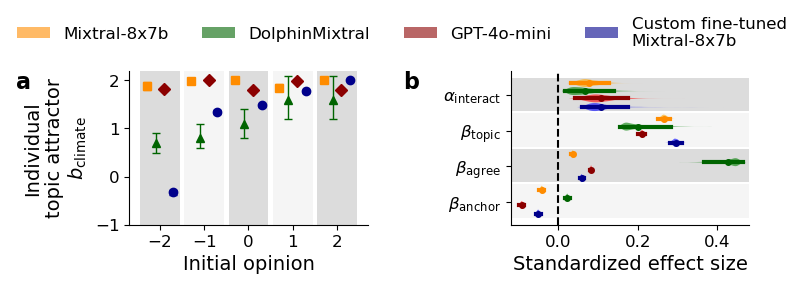

In [ ]:
from matplotlib.patches import Patch, Rectangle

# FIGURE & AXES
# ---------------------------------------------------
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(8, 2),       #   width x height in inches
)
fig.subplots_adjust(wspace=0.6)

# ===================================================
# 1)  INDIVIDUAL TOPIC‑ATTRACTOR ↔ INITIAL OPINION
# ===================================================
labels        = ['Fine-tuned', 'Mixtral-8x7b', 'DolphinMixtral', 'GPT-4o-mini']
markers       = ['o', 's', '^', 'D']
marker_colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred']

for i, label in enumerate(labels):
    # error‑bar points
    offsets  = [0.3, -0.3, -0.1, 0.1]


    ax1.errorbar(
        init_ops+offsets[i],
        data[i, 3:-6, 0],
        yerr=[data[i, 3:-6, 1], data[i, 3:-6, 2]],
        fmt=markers[i],
        ecolor=marker_colors[i],
        mec=marker_colors[i],
        mfc=marker_colors[i],
        label=label,
        capsize=3, elinewidth=1, capthick=1,
        alpha=1, zorder=5-i,
    )

for i in range(5):
    rect = Rectangle(
    (-2.45+i, -1.55), 0.9, 4,
    facecolor='gainsboro' if i % 2 == 0 else 'whitesmoke',
    zorder=-100
    )
    ax1.add_patch(rect)


# cosmetics
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlabel('Initial opinion', fontsize=14)
ax1.set_ylabel('Individual\ntopic attractor\n'+r"$b_\text{climate}$", fontsize=14)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_yticks([-1, 0, 1, 2])
ax1.set_xticks([-2, -1, 0, 1, 2])
ax1.set_ylim(-1, 2.2)


# ===================================================
# 2)  FOREST/VIOLIN PLOT OF STANDARDISED EFFECT SIZES
# ===================================================
params        = ["alpha", "beta_t", "beta_a", "beta_c"]
param_labels  = [r"$\alpha_\text{interact}$",
                 r"$\beta_{\text{topic}}$",
                 r"$\beta_{\text{agree}}$",
                 r"$\beta_{\text{anchor}}$"]
llms          = ["LLM_1", "LLM_2", "LLM_3", "LLM_4"]
llm_labels    = ["Custom fine-tuned\nMixtral-8x7b", "Mixtral-8x7b", "DolphinMixtral", "GPT-4o-mini"]

posterior = {
    "LLM_1": {"alpha": effect_sizes[0],  "beta_t": effect_sizes[1],
              "beta_a": effect_sizes[2], "beta_c": effect_sizes[3]},
    "LLM_2": {"alpha": effect_sizes[4],  "beta_t": effect_sizes[5],
              "beta_a": effect_sizes[6], "beta_c": effect_sizes[7]},
    "LLM_3": {"alpha": effect_sizes[8],  "beta_t": effect_sizes[9],
              "beta_a": effect_sizes[10],"beta_c": effect_sizes[11]},
    "LLM_4": {"alpha": effect_sizes[12], "beta_t": effect_sizes[13],
              "beta_a": effect_sizes[14],"beta_c": effect_sizes[15]},
}

# colour maps
violin_col = {"LLM_1": "blue", "LLM_2": "orange", "LLM_3": "green", "LLM_4": "red"}
hdi_col    = {"LLM_1": "darkblue", "LLM_2": "darkorange", "LLM_3": "darkgreen", "LLM_4": "darkred"}

# y‑axis group positions
base_y   = np.linspace(0, 4, 4)[::-1]                  # one band per parameter
offsets  = {"LLM_1": -0.45, "LLM_2": 0.45, "LLM_3": 0.15, "LLM_4": -0.125}

for p_i, param in enumerate(params):
    for llm in llms:  # first two LLMs only? (match original)
        draws  = posterior[llm][param]
        y_pos  = base_y[p_i] + offsets[llm]

        # violin
        parts = ax2.violinplot(draws, positions=[y_pos], vert=False,
                               widths=0.3, showmeans=False, showextrema=False,
                               showmedians=False)
        parts["bodies"][0].set_facecolor(violin_col[llm])
        parts["bodies"][0].set_edgecolor("none")
        parts["bodies"][0].set_alpha(0.6)

        # HDI & mean
        hdi_low, hdi_high = az.hdi(draws, hdi_prob=0.95)
        mean = draws.mean()
        ax2.plot([hdi_low, hdi_high], [y_pos, y_pos], color=hdi_col[llm], lw=3)
        ax2.plot(mean, y_pos, marker="o", color=hdi_col[llm], markersize=4)

    # alternating shaded background band
    rect = Rectangle(
        (-2, base_y[p_i] - 0.6), 5, 1.25,
        facecolor='gainsboro' if p_i % 2 == 0 else 'whitesmoke',
        zorder=-100
    )
    ax2.add_patch(rect)

# cosmetics
ax2.axvline(0, linestyle="--", color="black", zorder=-2, lw=1.5)
ax2.set_yticks(base_y)
ax2.set_yticklabels(param_labels)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel("Standardized effect size", fontsize=14)
ax2.set_xlim(-0.12, 0.48)
ax2.spines[["top", "right"]].set_visible(False)

# legend
handles = [Patch(facecolor=hdi_col[llm], edgecolor="none",
                 alpha=0.6, label=llm_labels[i])
           for i, llm in enumerate(llms)]


custom_order = [1, 2, 3, 0]


ax2.legend([handles[i] for i in custom_order],
           [llm_labels[i] for i in custom_order],
           frameon=False, ncols=4, loc=(-2.1,1.1), fontsize=12)


ax1.text(-0.475, 1, 'a', transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')

ax2.text(-0.45, 1, 'b', transform=ax2.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')


# ---------------------------------------------------
# EXPORT / DISPLAY
# ---------------------------------------------------

plt.savefig("../../plots/figure_5.png", dpi=400, bbox_inches="tight")
plt.show()